In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from idlmam import train_network, Flatten, weight_reset, View, set_seed
from idlmam import AttentionAvg, GeneralScore, DotScore, AdditiveAttentionScore, ApplyAttention, getMaskByFill

In [2]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

from IPython.display import display_pdf
from IPython.display import Latex

In [3]:
torch.backends.cudnn.deterministic=True
set_seed(42)

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
B = 128
epochs = 10

In [6]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import re

all_data = []
resp = urlopen("https://download.pytorch.org/tutorial/data.zip")
zipfile = ZipFile(BytesIO(resp.read()))
for line in zipfile.open("data/eng-fra.txt").readlines():
    line = line.decode('utf-8').lower()#lower case only please
    line = re.sub(r"[-.!?]+", r" ", line)#no puntuation
    source_lang, target_lang = line.split("\t")[0:2]
    all_data.append( (source_lang.strip(), target_lang.strip()) ) #(english, french)

In [7]:
for i in range(10):
    print(all_data[i])

('go', 'va')
('run', 'cours')
('run', 'courez')
('wow', 'ça alors')
('fire', 'au feu')
('help', "à l'aide")
('jump', 'saute')
('stop', 'ça suffit')
('stop', 'stop')
('stop', 'arrête toi')


In [8]:
short_subset = [] #the subset we will actually use
MAX_LEN = 6
for (s, t) in all_data:
    if max(len(s.split(" ")), len(t.split(" "))) <= MAX_LEN:
        short_subset.append((s,t))
print("Using ", len(short_subset), "/", len(all_data))

Using  66251 / 135842


In [9]:
SOS_token = "<SOS>" #"START_OF_SENTANCE_TOKEN"
EOS_token = "<EOS>" #"END_OF_SENTANCE_TOKEN"
PAD_token = "_PADDING_"

word2indx = {PAD_token:0, SOS_token:1, EOS_token:2}
for s, t in short_subset:
    for sentance in (s, t):
        for word in sentance.split(" "):
            if word not in word2indx:
                word2indx[word] = len(word2indx)
print("Size of Vocab: ", len(word2indx))
#build the inverted dict for looking at the outputs later
indx2word = {}
for word, indx in word2indx.items():
    indx2word[indx] = word

Size of Vocab:  24577


In [10]:
class TranslationDataset(Dataset):
    """
    Takes a dataset with tuples of strings (x, y) and
    converts them to tuples of int64 tensors. 
    This makes it easy to encode Seq2Seq problems.
    
    Strings in the input and output targets will be broken up by spaces
    """

    def __init__(self, lang_pairs, word2indx):
        """
        lang_pairs: a List[Tuple[String,String]] containing the source,target pairs for a Seq2Seq problem. 
        word2indx: a Map[String,Int] that converts each word in an input string into a unique ID. 
        """
        self.lang_pairs = lang_pairs
        self.word2indx = word2indx

    def __len__(self):
        return len(self.lang_pairs)

    def __getitem__(self, idx):
        x, y = self.lang_pairs[idx]
        x = SOS_token + " " + x + " " + EOS_token
        y = y + " " + EOS_token
        
        #convert to lists of integers
        x = [self.word2indx[w] for w in x.split(" ")]
        y = [self.word2indx[w] for w in y.split(" ")]
        
        x = torch.tensor(x, dtype=torch.int64)
        y = torch.tensor(y, dtype=torch.int64)
        
        return x, y
bigdataset = TranslationDataset(short_subset, word2indx)

In [11]:
#Want a consistent dataset split
set_seed(42)

In [12]:
train_size = round(len(bigdataset)*0.9)
test_size = len(bigdataset)-train_size
train_dataset, test_dataset = torch.utils.data.random_split(bigdataset, [train_size, test_size])

def pad_batch(batch):
    """
    Pad items in the batch to the length of the longest item in the batch
    """
    #We actually have two different maxiumum lengths! The max length of the input sequences, and the max 
    #length of the output sequences. So we will determine each seperatly, and only pad the inputs/outputs
    #by the exact amount we need
    max_x = max([i[0].size(0) for i in batch])
    max_y = max([i[1].size(0) for i in batch])
    
    PAD = word2indx[PAD_token]
    
    #We will use the F.pad function to pad each tensor to the right
    X = [F.pad(i[0], (0,max_x-i[0].size(0)), value=PAD) for i in batch]
    Y = [F.pad(i[1], (0,max_y-i[1].size(0)), value=PAD) for i in batch]
    
    X, Y = torch.stack(X), torch.stack(Y)
    
    return (X, Y), Y

train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True, collate_fn=pad_batch)
test_loader = DataLoader(test_dataset, batch_size=B, collate_fn=pad_batch)

In [13]:
class Seq2SeqAttention(nn.Module):

    def __init__(self, num_embeddings, embd_size, hidden_size, padding_idx=None, layers=1, max_decode_length=20):
        super(Seq2SeqAttention, self).__init__()
        self.padding_idx = padding_idx
        self.hidden_size = hidden_size
        self.embd = nn.Embedding(num_embeddings, embd_size, padding_idx=padding_idx)
        
        #We set the hidden size to half the intended length, because we will make the 
        #encoder bi-directional. That means we will get 2 hidden state representations
        #which we will concatinate together, giving us the desired size!
        self.encode_layers = nn.GRU(input_size=embd_size, hidden_size=hidden_size//2, 
                                       num_layers=layers, bidirectional=True)
        #decoder will be uni-directionall, and we need to use CRUCells so that we can 
        #do the decoding one step at a time
        self.decode_layers = nn.ModuleList([nn.GRUCell(embd_size, hidden_size)] + 
                                     [nn.GRUCell(hidden_size, hidden_size) for i in range(layers-1)])
        self.score_net = DotScore(hidden_size)
        #predict_word will be a small fully connected network that we use to convert the 
        #result of the attention mechanism and the local context into a prediction for 
        #the next word
        self.predict_word = nn.Sequential(
            nn.Linear(2*hidden_size, hidden_size),
            nn.LeakyReLU(),
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, num_embeddings)
        )
        self.max_decode_length = max_decode_length
        self.apply_attn = ApplyAttention()
    
    def forward(self, input):
        #Input should be (B, T) or ((B, T), (B, T'))
        if isinstance(input, tuple):
            input, target = input
        else:
            target = None
        #What is the batch size?
        B = input.size(0)
        #What is the max number of input time steps?
        T = input.size(1)

        x = self.embd(input) #(B, T, D)

        #grab the device that the model currently resides on
        #we will need this later 
        device = x.device

        mask = getMaskByFill(x)

        #We will use the mask to figure out how long 
        #each input sequence is
        seq_lengths = mask.sum(dim=1).view(-1) #shape (B), containing the # of non-zero values
        #the sequence lengths will be used to create a packed input for the encoder RNN
        x_packed = pack_padded_sequence(x, seq_lengths.cpu(), batch_first=True, enforce_sorted=False)
        h_encoded, h_last = self.encode_layers(x_packed)
        h_encoded, _ = pad_packed_sequence(h_encoded) #(B, T, 2, D//2) , b/c its bidirectional
        h_encoded = h_encoded.view(B, T, -1) #(B, T, D)
        #now h_encoded is the result of running the encoder RNN on the input!


        #getting the last hidden state is a little trickier
        #first the output gets reshaped as (num_layers, directions, batch_size, hidden_size)
        #and then we grab the last index in the first dimension, because we want the 
        #last layer's output
        hidden_size = h_encoded.size(2) 
        h_last = h_last.view(-1, 2, B, hidden_size//2)[-1,:,:,:] #shape is now (2, B, D/2)
        #now we will reorder to (B, 2, D/2), and flatten the last two dimensions down to (B, D)
        h_last = h_last.permute(1, 0, 2).reshape(B, -1)
        
        
        #End of Encoding portion. h_encoded now contains the representation of the input data!
        #h_last has the final ouputs of the RNN, to use as the initial input state for the decoder
        
        #The first input to the decoder will be the output of the last encoder step
        #decoder_input = h_last
        
        # new hidden states for decoders
        h_prevs = [h_last for l in range(len(self.decode_layers))]

        #We will save all the attention mechanism results for visualization later!
        all_attentions = []
        all_predictions = []

        #Grab the last item from the input (which should be an EOS marker)
        #as the first input for the decoder
        #We could also hard-code the SOS marker instead
        decoder_input = self.embd(input.gather(1,seq_lengths.view(-1,1)-1).flatten()) #(B, D)

        #How many decoding steps should we do?
        steps = min(self.max_decode_length, T)
        #If we are training, the target values tells us exactly
        #how many steps to take
        if target is not None: #We know the exact decode length!
            steps = target.size(1)
        
        #Do we use teacher forcing (true) or auto-regressive (false)
        teacher_forcing = np.random.choice((True,False))
        for t in range(steps):
            x_in = decoder_input #(B, D)

            for l in range(len(self.decode_layers)):
                h_prev = h_prevs[l] 
                h = self.decode_layers[l](x_in, h_prev)

                h_prevs[l] = h
                x_in = h
            h_decoder = x_in #(B, D), we now have the hidden state for the decoder at this time step

            #This is the attention mechanism, lets look at all the previous encoded states and 
            #see which look relevant

            scores = self.score_net(h_encoded, h_decoder) #(B, T, 1)
            context, weights = self.apply_attn(h_encoded, scores, mask=mask)

            #save the attention weights for visualization later
            all_attentions.append( weights.detach() ) #we are detaching the weights because we 
            #do not want to compute anything with them anymore, we just want to save their 
            #values to make visualizations

            #Now lets compute the final representation by concatinating the 
            #attention result and the initial context
            word_pred = torch.cat((context, h_decoder), dim=1) #(B, D) + (B, D)  -> (B, 2*D)
            #and get a prediction about what the next token is by pushing it
            #through a small fully-connected network
            word_pred = self.predict_word(word_pred) #(B, 2*D) -> (B, V)
            all_predictions.append(word_pred)
    
            #Now we have $\hat{y}_t$! we need to select the input for the next
            #time step. We use torch.no_grad() because the gradient will 
            #carry through the hidden states of the RNN, not the input tokens
            with torch.no_grad():
                if self.training:
                    if target is not None and teacher_forcing:
                        #We have the target and selected teacher forcing, so use the
                        #correct next answer
                        next_words = target[:,t].squeeze()
                    else:
                        #Sample the next token based on the predictions made
                        next_words = torch.multinomial(F.softmax(word_pred, dim=1), 1)[:,-1]
                else:
                    #we are trying to make an actual prediction, so take the most likely word
                    #we could improve this by using temperature and sampling like we did 
                    #for the CharRNN model!
                    next_words = torch.argmax(word_pred, dim=1)
            #end of torch.no_grad()
            
            #We've decided what the next tokens are, we are back to using
            #the gradient calculation so that the embedding layer is adjusted
            #appropriately during training. 
            decoder_input = self.embd(next_words.to(device))
    
        #done decoding!
        if self.training: #When training, only the predictions are important
            return torch.stack(all_predictions, dim=1)
        else:#When evaluatin, we also want to look at the attention weights
            return torch.stack(all_predictions, dim=1), torch.stack(all_attentions, dim=1).squeeze()

In [14]:
set_seed(42)

In [15]:
epochs = 20
seq2seq = Seq2SeqAttention(len(word2indx), 64, 256, padding_idx=word2indx[PAD_token], layers=3, max_decode_length=MAX_LEN+2)
for p in seq2seq.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -10, 10))

In [16]:
def CrossEntLossTime(x, y):
    """
    x: output with shape (B, T, V)
    y: labels with shape (B, T')
    
    """
    if isinstance(x, tuple):
        x, _ = x
    #We do not want to compute a loss for items that have been padded out!
    cel = nn.CrossEntropyLoss(ignore_index=word2indx[PAD_token])
    T = min(x.size(1), y.size(1))
    
    loss = 0
    for t in range(T):
        loss += cel(x[:,t,:], y[:,t])
    return loss

In [17]:
seq2seq_results = train_network(seq2seq, CrossEntLossTime, train_loader,epochs=epochs, device=device)

<AxesSubplot:xlabel='epoch', ylabel='train loss'>

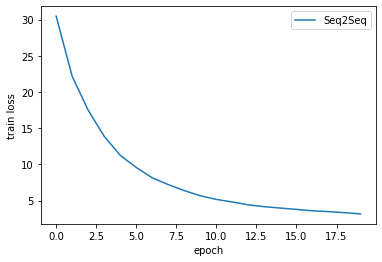

In [18]:
sns.lineplot(x='epoch', y='train loss', data=seq2seq_results, label='Seq2Seq')

In [19]:
def plot_heatmap(src, trg, scores):
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(scores, cmap='gray')

    ax.set_xticklabels(trg, minor=False, rotation='vertical')
    ax.set_yticklabels(src, minor=False)

    # put the major ticks at the middle of each cell
    # and the x-ticks on top
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(scores.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(scores.shape[0]) + 0.5, minor=False)
    ax.invert_yaxis()

    plt.colorbar(heatmap)
    plt.show()

In [20]:
seq2seq = seq2seq.eval().cpu()
def results(indx):
    eng_x, french_y = test_dataset[indx]
    eng_str = " ".join([indx2word[i] for i in eng_x.cpu().numpy()])
    french_str = " ".join([indx2word[i] for i in french_y.cpu().numpy()])
    print("Input:     ", eng_str)
    print("Target:    ", french_str)
    
    with torch.no_grad():
        preds, attention = seq2seq(eng_x.unsqueeze(0))
        p = torch.argmax(preds, dim=2)
    pred_str = " ".join([indx2word[i] for i in p[0,:].cpu().numpy()])
    print("Predicted: ", pred_str)
    plot_heatmap(eng_str.split(" "), pred_str.split(" "), attention.T.cpu().numpy())

Input:      <SOS> some animals are afraid of fire <EOS>
Target:     certains animaux craignent le feu <EOS>
Predicted:  les animaux ont peur du feu <EOS> <EOS>


/home/edraff/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """
/home/edraff/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


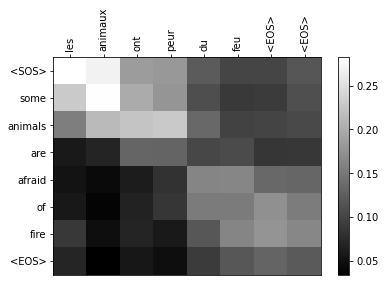

In [21]:
results(12) 

Input:      <SOS> what is the weather like today <EOS>
Target:     comment est le temps aujourd'hui <EOS>
Predicted:  quel temps fait il aujourd'hui <EOS> <EOS> <EOS>


/home/edraff/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """
/home/edraff/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


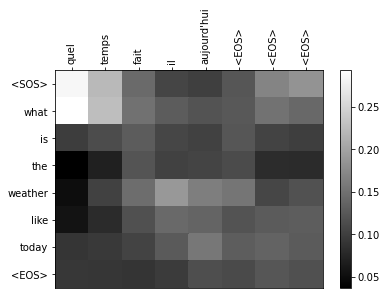

In [22]:
results(13) 

Input:      <SOS> no one disagreed <EOS>
Target:     personne ne fut en désaccord <EOS>
Predicted:  personne n'exprima de désaccord <EOS>


/home/edraff/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """
/home/edraff/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


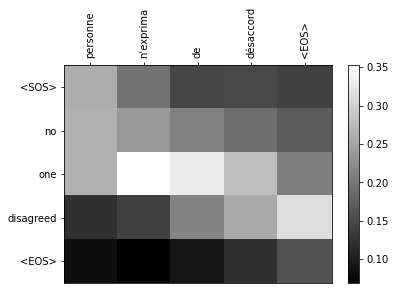

In [23]:
results(16) 